# 0.0 Imports & Setup

## 0.1 Imports

In [98]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec
import xgboost as xgb
import random
import pickle
import requests
#import warnings

#warnings.filterwarnings( 'ignore' )

from matplotlib import pyplot as plt
from IPython.display import Image
from scipy import stats
from tabulate import tabulate
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

In [2]:
np.random.seed(0)

## 0.2 Helper Functions

In [3]:
# Cramer com correção de viés
def cramer_v(x, y):
    
    tc = pd.crosstab(x, y).values
    n = tc.sum()
    r, k = tc.shape
    
    chi2 = stats.chi2_contingency(tc)[0]
    chi2_corrigido = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    k_corrigido = k - (k-1) **2 / (n-1)
    r_corrigido = r - (r-1) **2 / (n-1)
    
    return np.sqrt( chi2_corrigido/n / (min(k_corrigido-1, r_corrigido-1)))


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

## 0.3 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)


df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
982497,968,5,2013-02-01,7285,955,1,0,0,0,c,a,1190.0,NaN,NaN,0,NaN,NaN,NaN
719065,676,3,2013-09-25,6221,1563,1,1,0,0,b,b,1410.0,9.0,2008.0,0,NaN,NaN,NaN
145542,593,1,2015-03-23,8132,1107,1,0,0,0,a,c,33060.0,3.0,2010.0,0,NaN,NaN,NaN
252177,999,1,2014-12-15,20916,1136,1,1,0,0,d,c,15140.0,2.0,2002.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
479489,825,1,2014-04-28,5472,606,1,1,0,0,a,a,380.0,5.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [6]:
df_raw.shape

(1017209, 18)

## 0.4 Graphic Settings  -- ele não comentou sobre isso nos vídeos, eu só tinha usado o sns.set_style, e o rcParams de figsize

In [7]:
%matplotlib inline
%pylab inline

plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 24

#display( HTML( '<style>.container { width:100% !important; }</style>') )      nem sei o que faz,  mas só funcionou quando estava dentro de       def jupytyer_settings():
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set()

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1.0 Descrição dos Dados

## 1.1 Rename Columns

In [8]:
df1 = df_raw.copy()

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
#cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
#            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [12]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [13]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [15]:
df1.competition_distance.max()

75860.0

In [16]:
df1.date.min()

Timestamp('2013-01-01 00:00:00')

In [17]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [18]:
# competition_distance
# provavelmente, a distância é NA porque o competidor mais próximo fica muito longe, entõa considera-se que não tem competitior próximo. Podemos colocar um valor grande referente ao maior
# encontrado na coluna para preencher os NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
                     
# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year                       
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [19]:
# promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [100]:
df1.sample(5).T

,634035,493836,200191,199218,606724
store,386,677,607,749,950
day_of_week,2,2,1,2,6
date,2013-12-10 00:00:00,2014-04-15 00:00:00,2015-02-02 00:00:00,2015-02-03 00:00:00,2014-01-04 00:00:00
sales,7778,10662,5867,6300,4330
customers,653,800,584,668,445
open,1,1,1,1,1
promo,0,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,1,1,0,0
store_type,d,d,a,a,a


## 1.6 Change Types   -  após fazer operações com colunas, verificar novamente os tipos das colunas

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics  -  1. Ganhar conhecimento de negócio, dos dados  -  2. Detectar alguns erros

In [24]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [25]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
26388,744,3,6815,744,1,0,0,1370.0,12,2011,1,40,2014,1
49384,325,3,6252,624,1,1,0,350.0,3,2011,1,22,2011,0


In [26]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
623041,0,a,a,"Jan,Apr,Jul,Oct",Dec
713614,0,d,a,0,Set


### 1.7.1 Numerical Attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index(0)
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [28]:
#num_attributes.describe().T

In [29]:
# skew proximo de 0 indica que a distribuição é parecida com uma normal
# a kurtosis perto de 1 indica que tem um pico muito grande

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


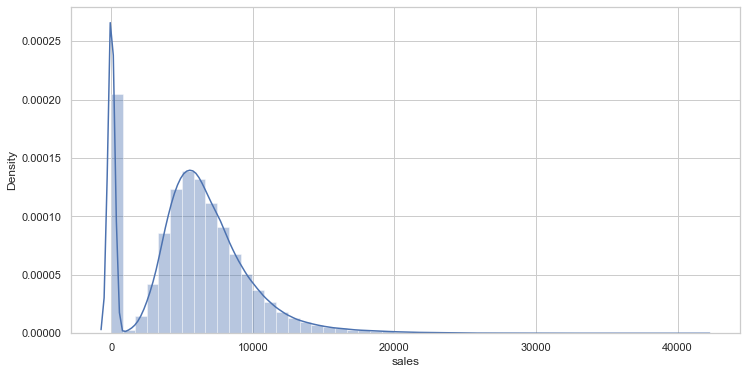

In [30]:
#fig = plt.figure(figsize=(16, 9))
plt.figure(figsize=(12, 6))
sns.distplot(df1['sales'])
plt.show()

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


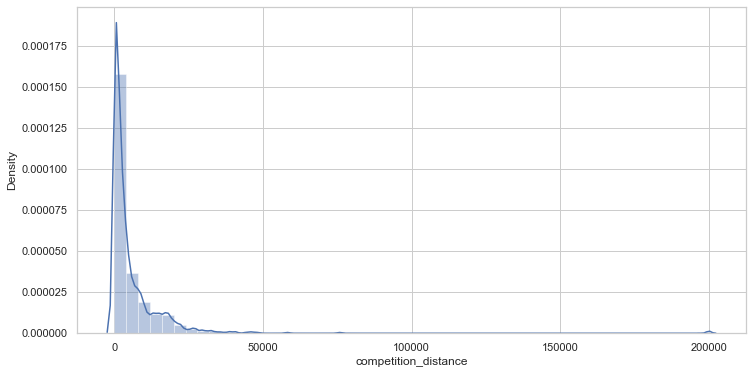

In [31]:
plt.figure(figsize=(12, 6))
sns.distplot(df1['competition_distance'])
plt.show()

### 1.7.2 Categorical Attributes

In [32]:
cat_attributes.promo_interval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [33]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

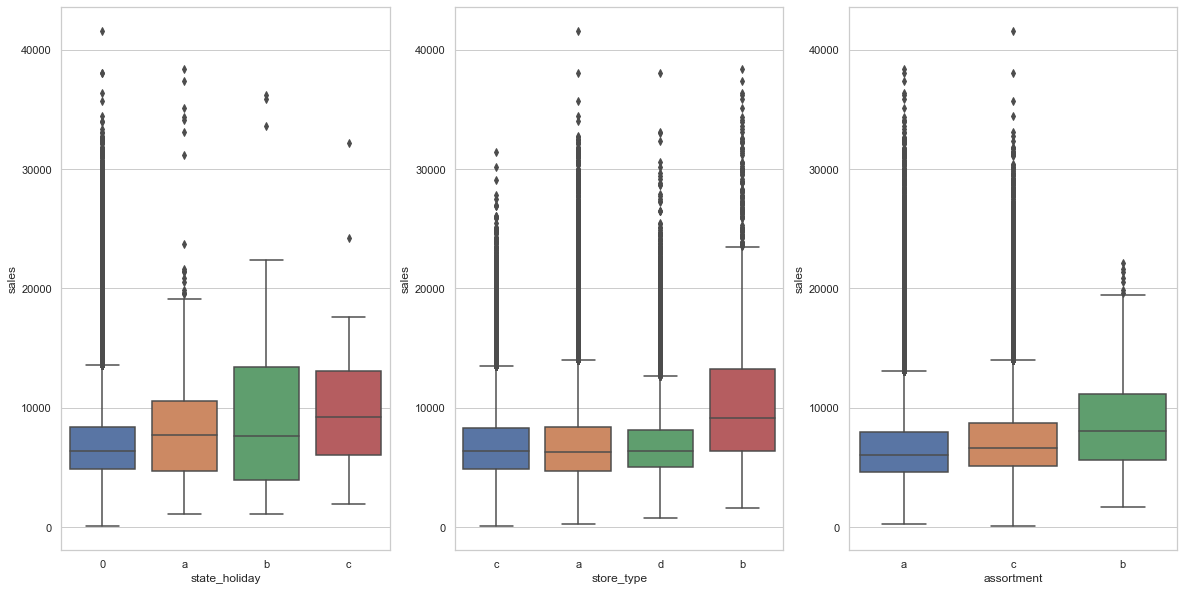

In [34]:
plt.figure(figsize=(20, 10))
aux1 = df1[(df1['state_holiday'] != 0) & df1['sales'] > 0]
# aux1 = df1[(df1['state_holiday'] != '0') & df1['sales'] > 0]  # -> tornar o 0 string, caso queira eliminar o state holiday = 0, sem feriado

plt.subplot(1, 3, 1)
sns.boxplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1, 3, 2)
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1, 3, 3)
sns.boxplot(data=aux1, x='assortment', y='sales')
plt.show()

# 2.0 Feature Engineering

In [35]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

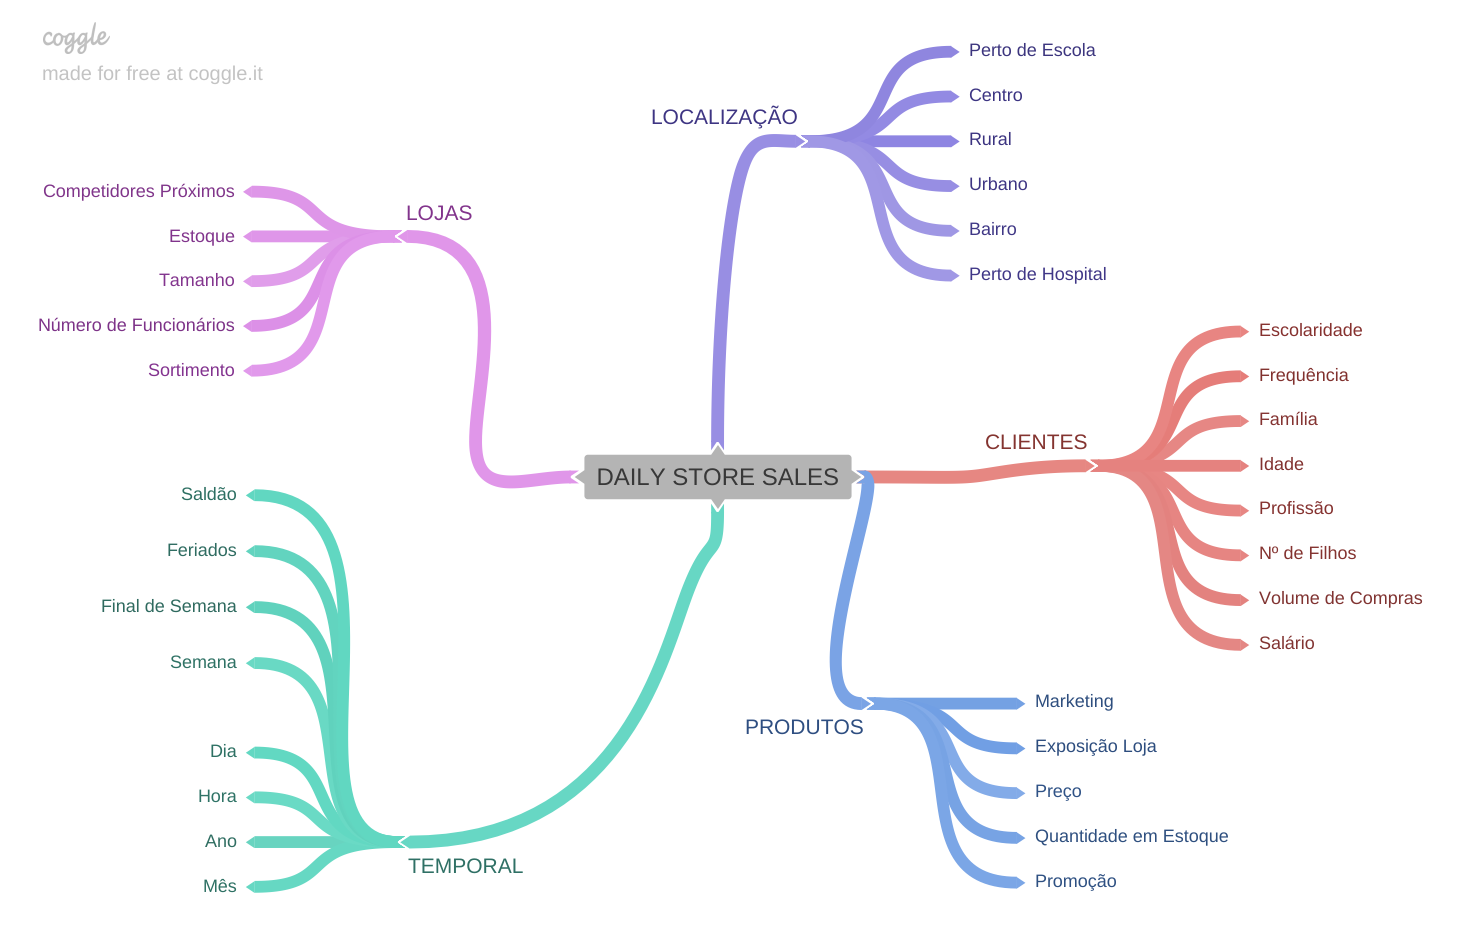

In [36]:
Image('img/mind_map_hypothesis.png')

## 2.1 Hypothesis Generation

### 2.1.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais. (mais quem tem mais estoque, pode ser porque vendeu menos também, não?)

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais. 

### 2.1.2 Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana. (wtf, tá maluco? é o contrário kkkkk)

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Hypothesis Final List

In [37]:
# priorizar as hipóteses pra poder depois usá-las lá no passo de análise exploratória de dados

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais. 

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana. (wtf, tá maluco? é o contrário kkkkk)

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [38]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [39]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)  
# não temos informação do dia, entao estamos supondo que começa dia 1 sempre
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

In [40]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [41]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [42]:
df2.sample(5).T

,704012,584755,265925,254157,187583
store,118,166,674,14,264
day_of_week,2,4,7,5,5
date,2013-10-08 00:00:00,2014-01-23 00:00:00,2014-11-30 00:00:00,2014-12-12 00:00:00,2015-02-13 00:00:00
sales,8175,5798,0,4764,5859
customers,694,796,0,572,806
open,1,1,0,1,1
promo,1,1,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,0,0,0,0
store_type,d,a,a,a,a


# 3.0 Filtragem de Variáveis

In [43]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [44]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] # (se a loja está fechada, as vendas vão ser 0...)

## 3.2 Seleção das Colunas

In [45]:
# após filtrar as linhas com open diferente de 0, a coluna open agora só tem valores iguais a 1
# não tenho como prever o número de clientes futuros no momento, então vou removê-la por uma restrição de negócio
# promo_interval e month_map foram colunas que utilizamos para criarmos outras
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados

In [47]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable (Variável Resposta)

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


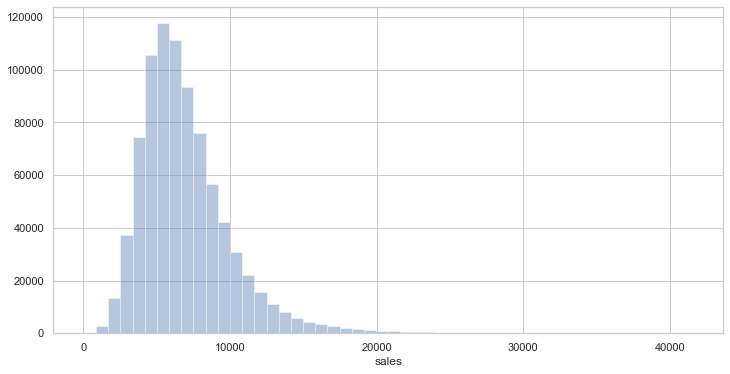

In [48]:
#sns.distplot(df4['sales'])
sns.distplot(df4['sales'], kde=False)
#sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Numerical Variables

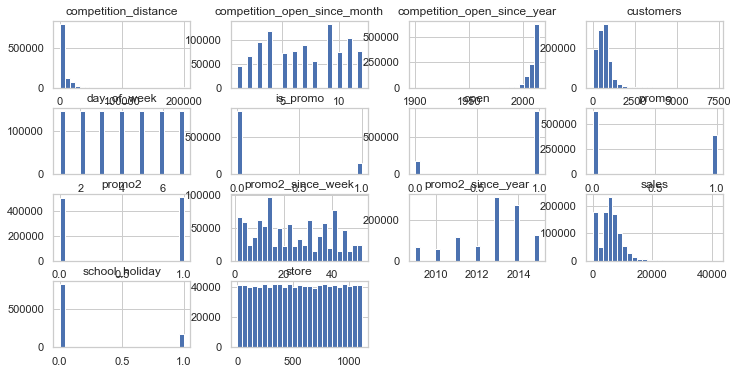

In [49]:
num_attributes.hist(bins=25);

In [50]:
correlacao = df4.corr()

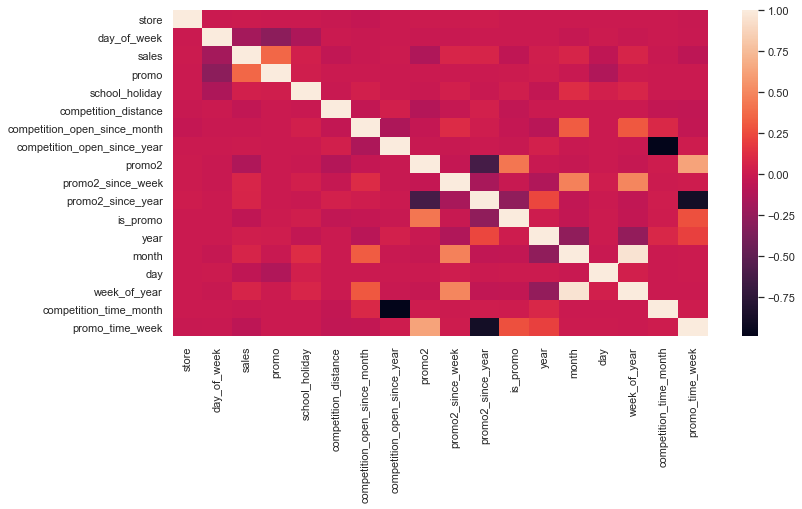

In [51]:
sns.heatmap(correlacao)

### 4.1.3 Categorical Variables

In [52]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWar

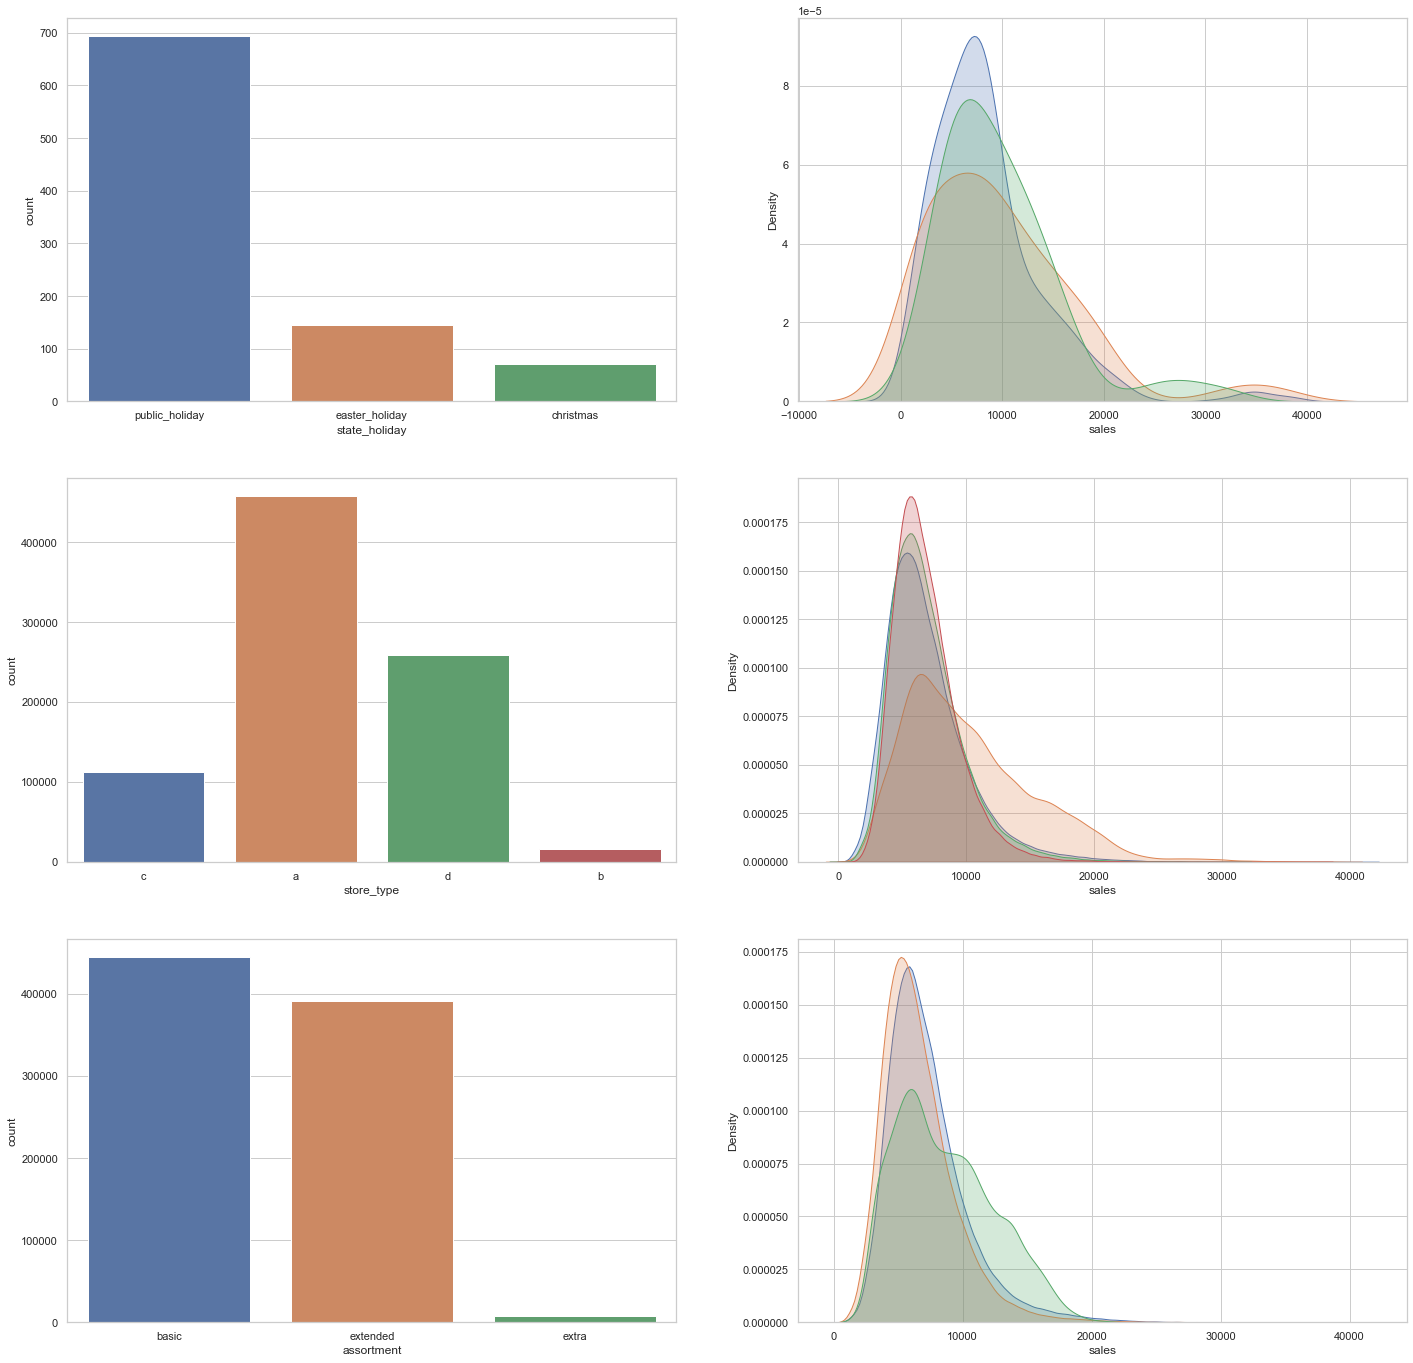

In [53]:
plt.figure(figsize=(24,24))
# A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable.

# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']  # a maioria dos dias são regular day, então distorcia o gráfico
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

# as outras duas são variaveis auxiliares que utilizamos para derivar outras

In [54]:
print(f"Extra Sales Mean: {df4[df4['assortment'] == 'extra']['sales'].mean()}")
print(f"Extra Sales Mean: {df4[df4['assortment'] == 'extended']['sales'].mean()}")
print(f"Extra Sales Mean: {df4[df4['assortment'] == 'basic']['sales'].mean()}")

Extra Sales Mean: 8642.503593616762
Extra Sales Mean: 7300.843546647447
Extra Sales Mean: 6621.523057038494


## 4.2 Análise Bivariada

### **Hipótese 1** Lojas com MAIOR SORTIMENTO deveriam vender MAIS. 
- ***Verdadeiro***

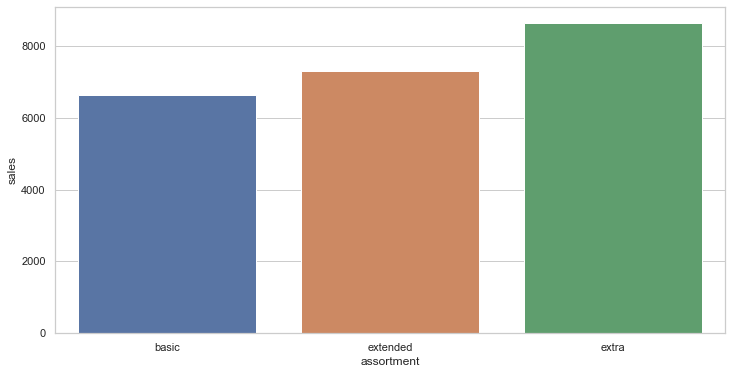

In [55]:
aux1 = df4[['assortment', 'sales']].groupby(('assortment')).mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

In [56]:
df4[['assortment', 'sales']].groupby(('assortment')).mean().reset_index()

,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


In [57]:
df4[['assortment', 'sales']].groupby(('assortment')).count().reset_index()

,assortment,sales
0,basic,444875
1,extended,391254
2,extra,8209


,year_week,assortment,sales
158,2013-52,extra,124552
317,2014-52,extra,196249


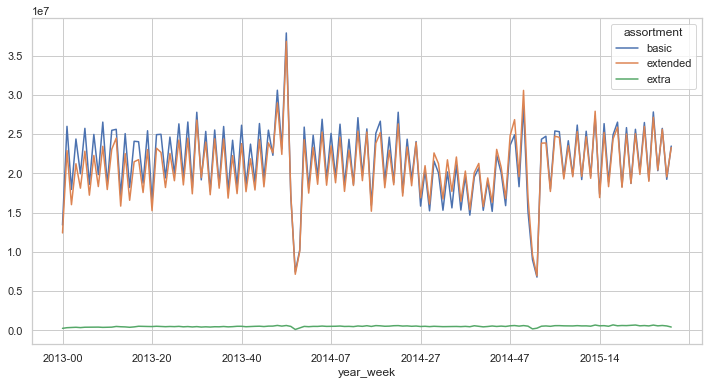

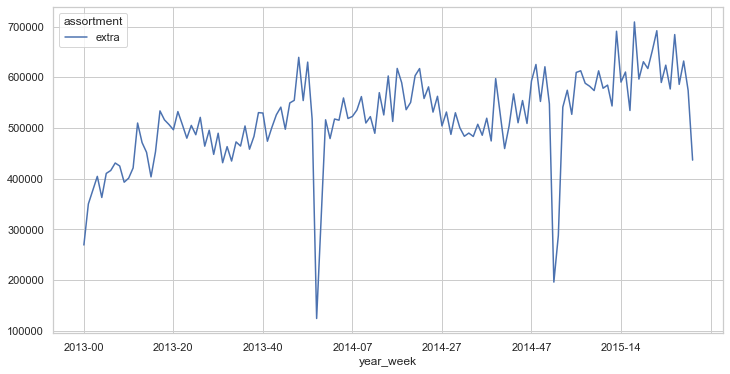

In [58]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3[aux3['sales'] < 200000] # são os dois pontos de queda no gráfico

### **Hipótese 2.** Lojas com competidores mais próximos deveriam vender menos.
- ***Falso***. Nós pensamos que com mais concorrência, haverão menos vendas, mas é possível que onde haja mais concorrentes próximos, a área é mais populosa e possui mais clientes no geral.
- Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

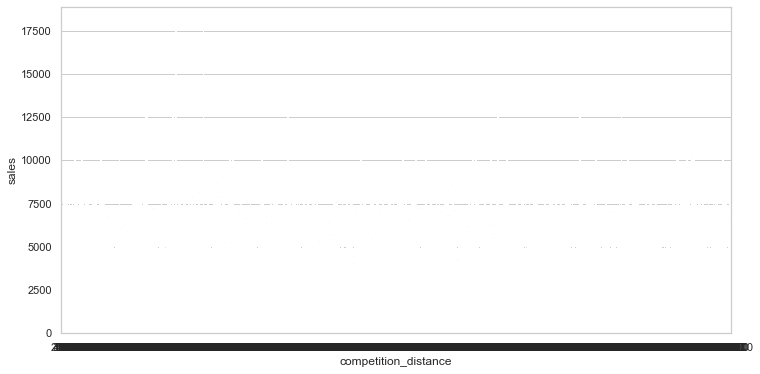

In [59]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index();
sns.barplot(data=aux1, x='competition_distance', y='sales');

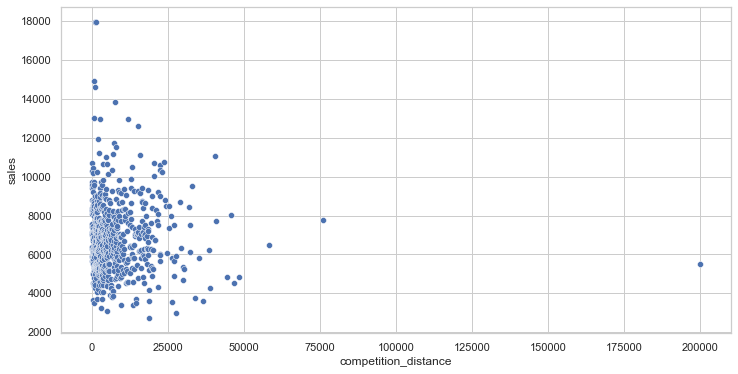

In [60]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).mean().reset_index()
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

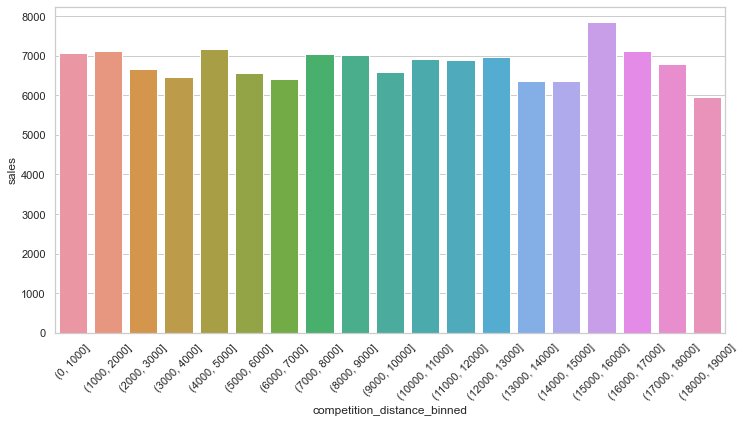

In [61]:
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=45);

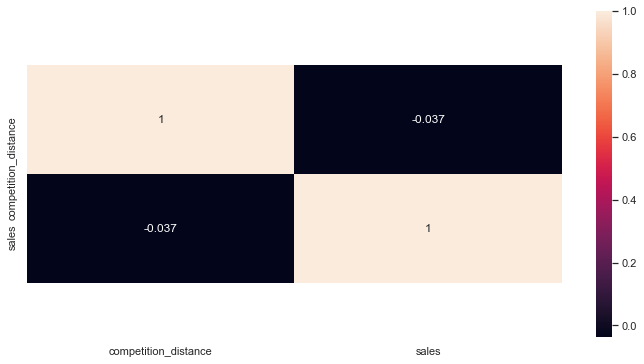

In [62]:
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

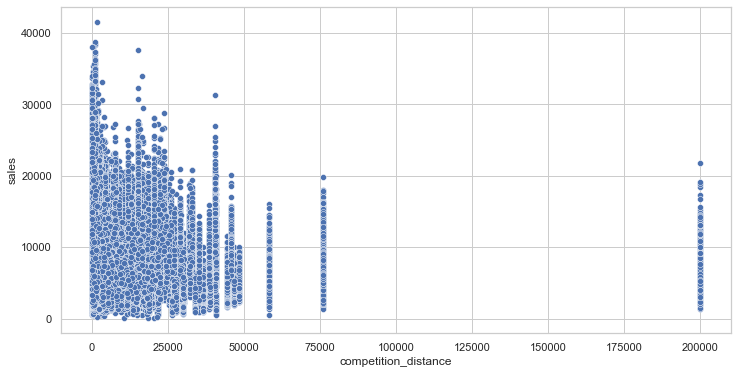

In [63]:
sns.scatterplot(data=df4, x='competition_distance', y='sales');

### **Hipótese 3.** Lojas com competidores há mais tempo deveriam vender mais. 
- Falso. Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

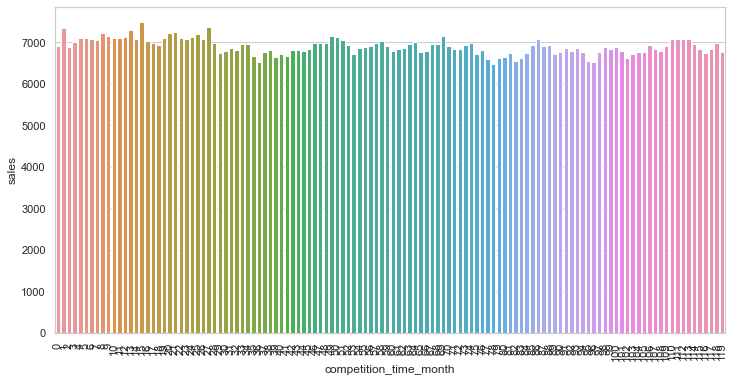

In [64]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] >= 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

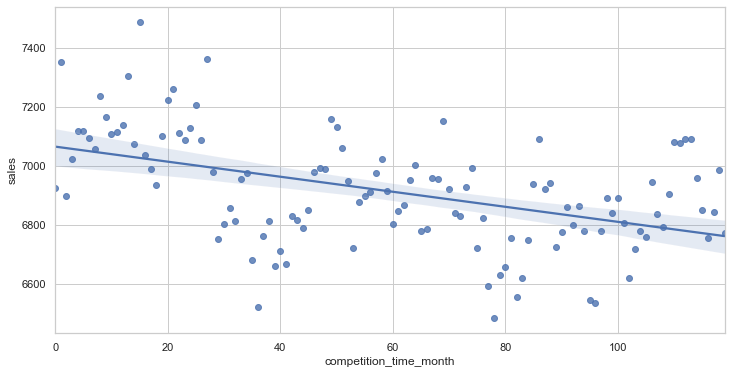

In [65]:
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

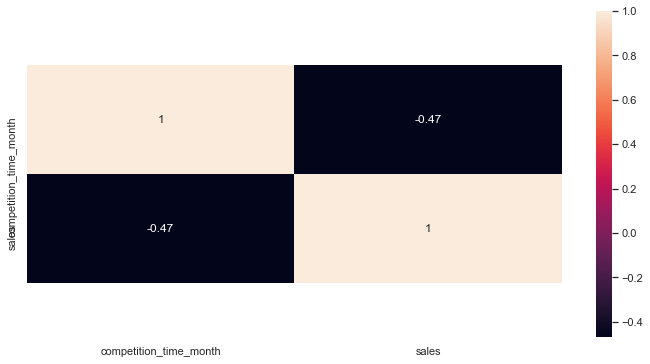

In [66]:
x = sns.heatmap( aux2.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### **Hipótese 4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
- Inconclusivo.
- Acho que quanto mais tempo das promoções extendidas, maiores as vendas. Entretanto, as promoções regulares não aumentam as vendas com o tempo.

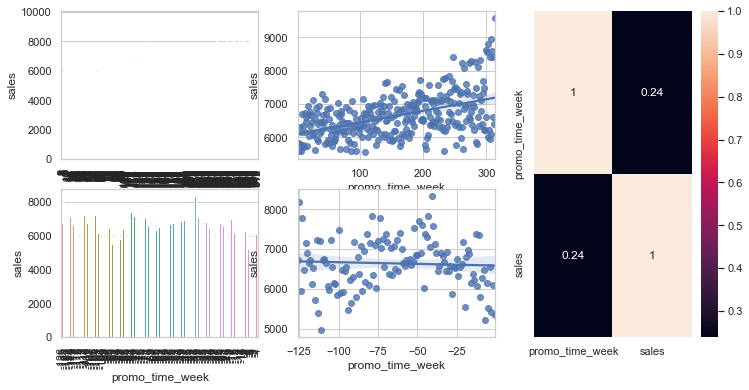

In [95]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()
grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

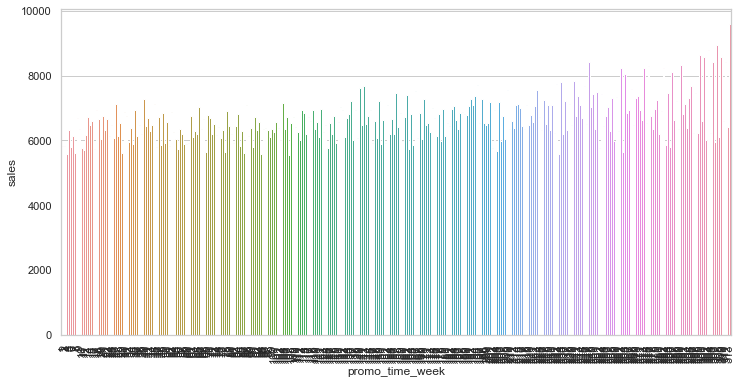

In [68]:
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

### <s>**Hipótese 5.** Lojas com mais dias de promoção deveriam vender mais.
Muito parecida com a hipótese anterior, além disso, precisaria criar uma nova variável.


Deixar para avaliá-la no segundo ciclo do CRISP.

### **Hipótese 6.** Lojas com mais promoções consecutivas deveriam vender mais.
- Falso, vende praticamente a mesma coisa, e segue o mesmo ritmo de crescimento e decaimento.
- Também não parece que vai ser uma variável útil pro modelo, pois os comportamentos de venda durante a promoção extenda e a tradição são muito similares.

In [69]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().sort_values('sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,8618.452062
1,1,1,7836.672987
2,0,0,6328.187633
3,0,1,5529.566684


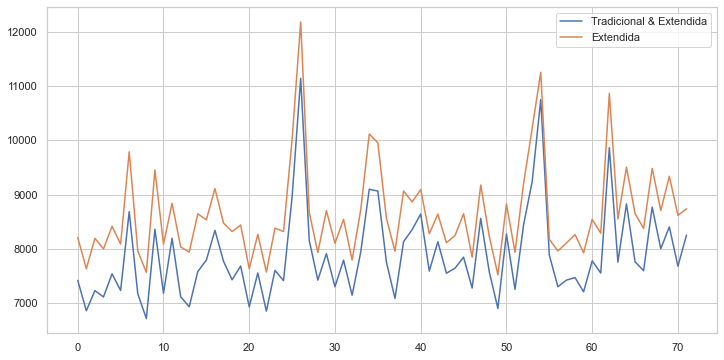

In [70]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

### **Hipótese 7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
- Verdadeiro. Se vende bem MAIS nos feriados do que em dias normais, principalmente no NATAL e PÁSCOA

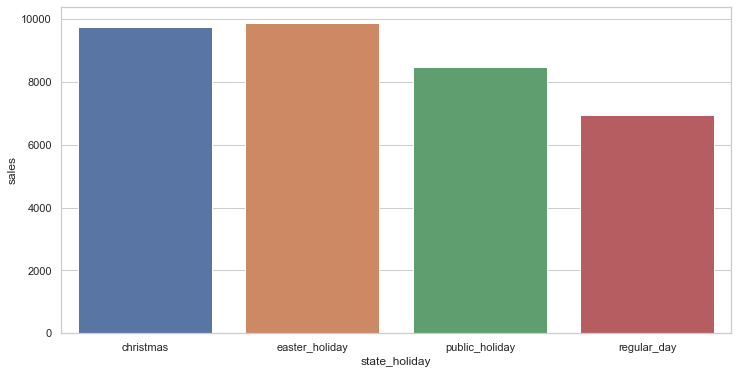

In [71]:
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

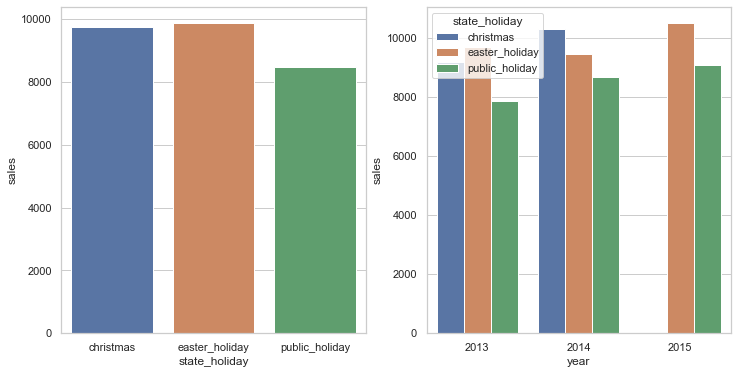

In [72]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **Hipótese 8.** Lojas deveriam vender mais ao longo dos anos.
- Verdadeiro. Nos 3 anos analisados, há um pequeno crescimento linear nas vendas médias ao longo dos anos.

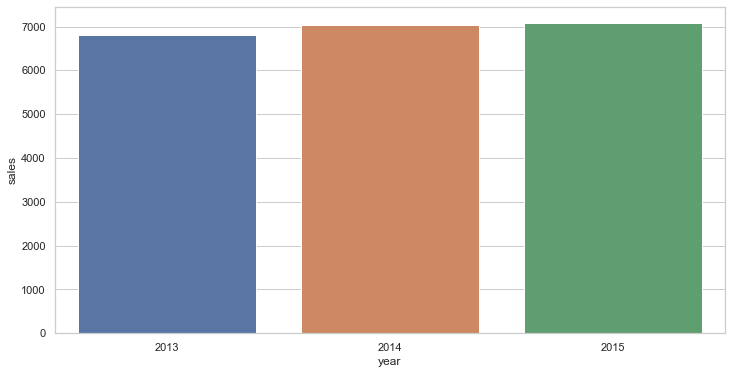

In [73]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

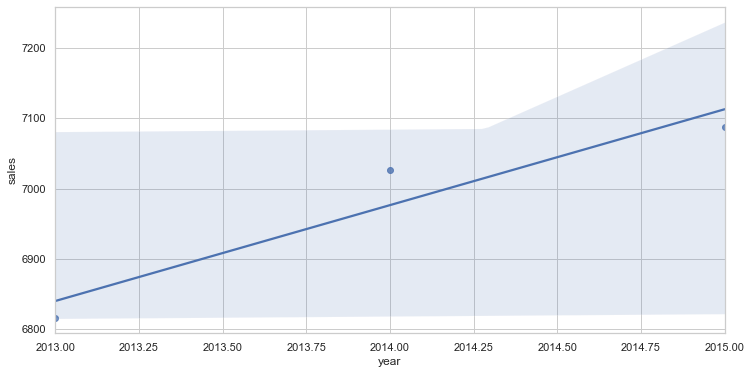

In [74]:
plt.figure(figsize=(12,6))
sns.regplot( x='year', y='sales', data=aux1 );

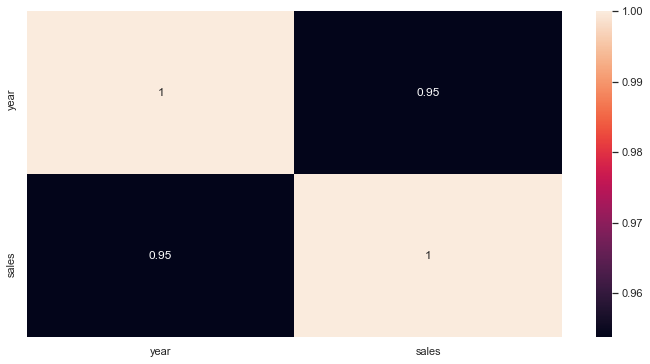

In [75]:
# que valor enorme de correlação! é porque realmente tem uma lineariedade ao longo dos anos
plt.figure(figsize=(12,6))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **Hipótese 9.** Lojas deveriam vender mais no segundo semestre do ano.
- Falso, as vendas são bem similares ao longo dos meses do ano, com exceção de Dezembro, que realmente possui um valor volume de vendas (embora não haja os dados do ano 2015)
- O comportamento da média das vendas parecem cíclico, primeiro cresce, depois descresce, e no fim do ano cresce novamente. O regplot mostra bem isso.

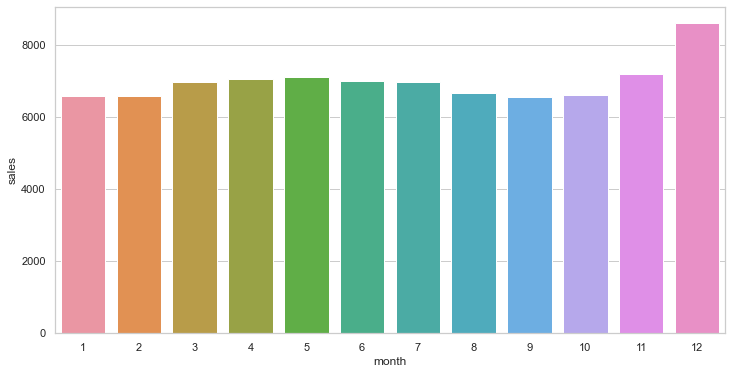

In [76]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

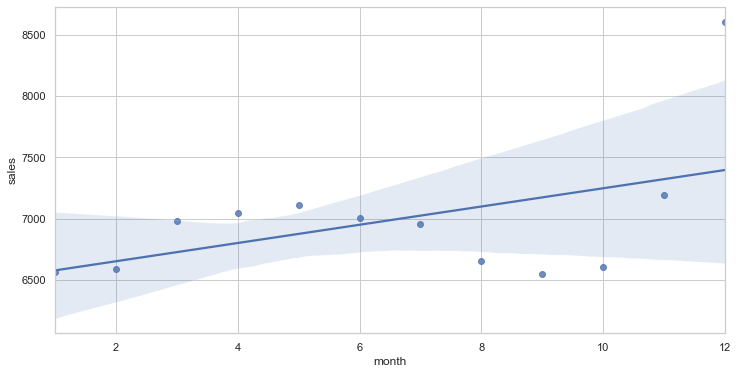

In [77]:
plt.figure(figsize=(12,6))
sns.regplot( x='month', y='sales', data=aux1 );

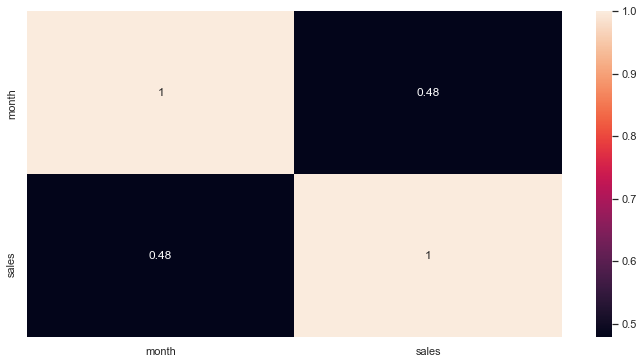

In [78]:
plt.figure(figsize=(12,6))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **Hipótese 10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
- Falso. Há novamente um comportamento cíclico, assim como nos meses. Há um decréscimo, seguido de um aumento das vendas, outra queda, e assim por diante...
- Analisando isoladamente, percebemos que em média, há mais vendas nos 10 primeiros dias do mês do que no restante.

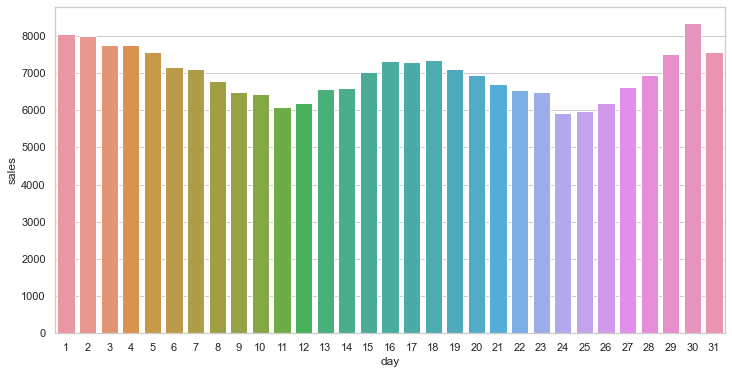

In [79]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

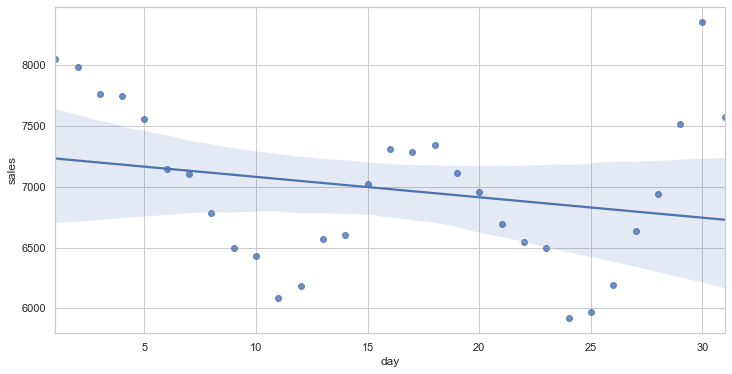

In [80]:
plt.figure(figsize=(12,6))
sns.regplot( x='day', y='sales', data=aux1 );

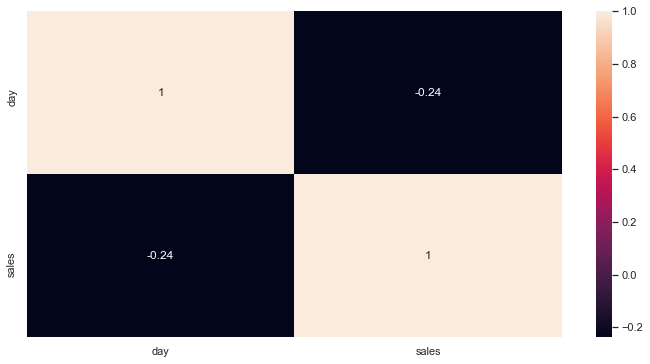

In [81]:
plt.figure(figsize=(12,6))
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

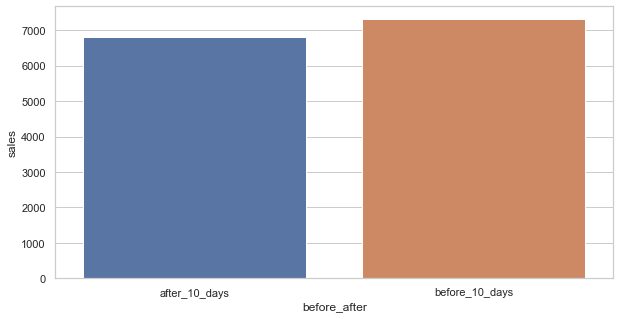

In [82]:
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot( x='before_after', y='sales', data=aux2 );

In [83]:
# realmente precisava de um gráfico pra isso? wtf
# a maioria das coisas dessas hipóteses acho que só uma média simples bastaria, eu hein. Mas as vezes é importante vê o comportamento ao longo do tempo mesmo.
aux2

,before_after,sales
0,after_10_days,6824.773314
1,before_10_days,7307.762933


### **Hipótese 11.** Lojas deveriam vender menos nos finais de semana.
- Aparentemente, as lojas abrem pouco aos domingos, ou apenas algumas delas abrem. Entretanto, a média de venda aos domingos aparente ser a mais alta. Em contrapartida, as vendas no sábado são menores do que qualquer outro dia da semana.
- Portanto, a conclusão é de que esta hipótese é inconclusiva.
- Ou então, podemos mudá-la para: AS LOJAS VENDEM MENOS AOS SÁBADOS e VENDEM MAIS AOS DOMINGOS

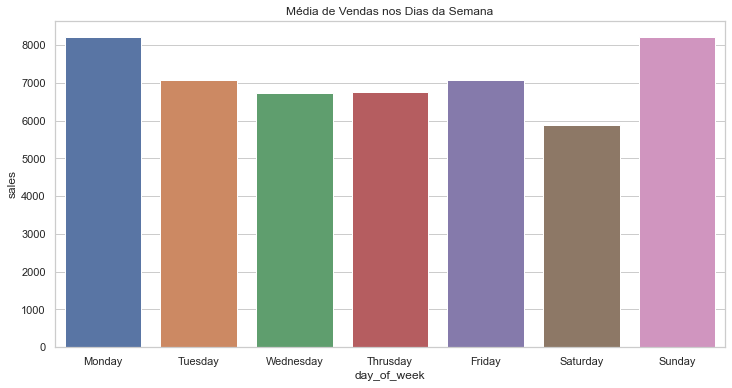

In [102]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.title('Média de Vendas nos Dias da Semana')
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

In [85]:
aux1

,day_of_week,sales
0,1,8216.252259
1,2,7088.409086
2,3,6728.786679
3,4,6768.214973
4,5,7073.034133
5,6,5875.084935
6,7,8224.723908


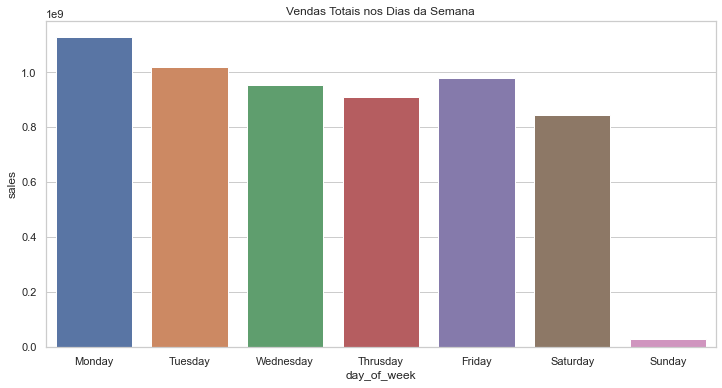

In [103]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.title('Vendas Totais nos Dias da Semana');
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

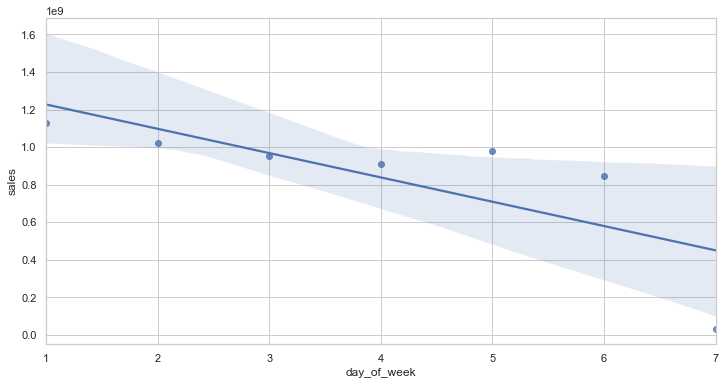

In [87]:
sns.regplot( x='day_of_week', y='sales', data=aux1 );

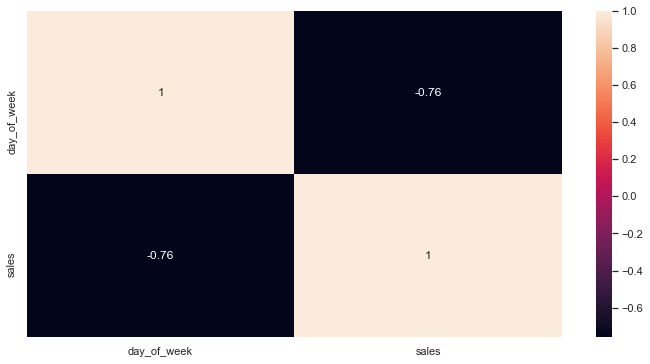

In [88]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **Hipótese 12.** Lojas deveriam vender menos durante os feriados escolares.
- Falso. As lojas vendem MAIS durante os feriados escolares. Analisando mês a mês, o único mês no qual se vende MENOS nos feriados escolares é em Dezembro.

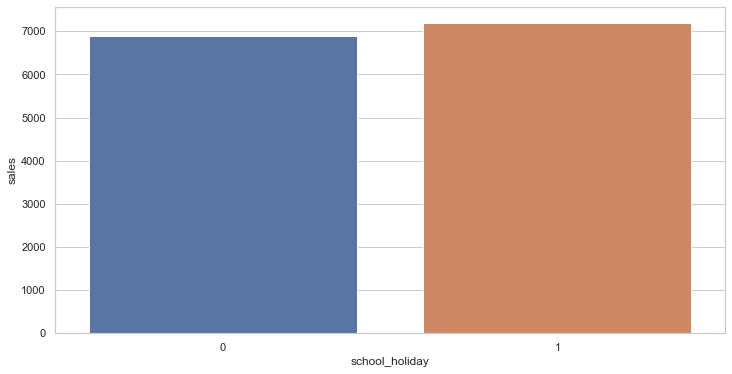

In [89]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()

sns.barplot( x='school_holiday', y='sales', data=aux1 );

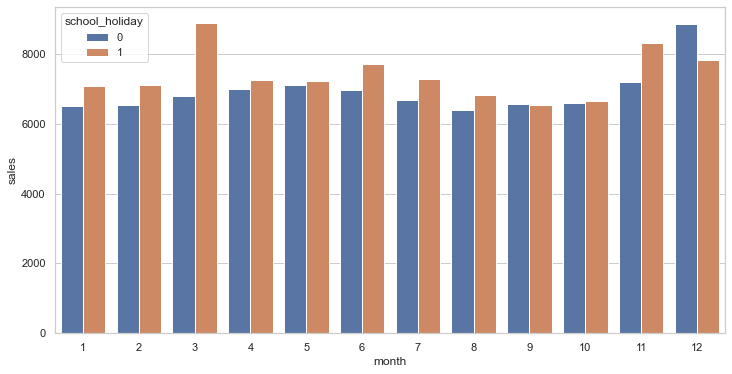

In [90]:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()

sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

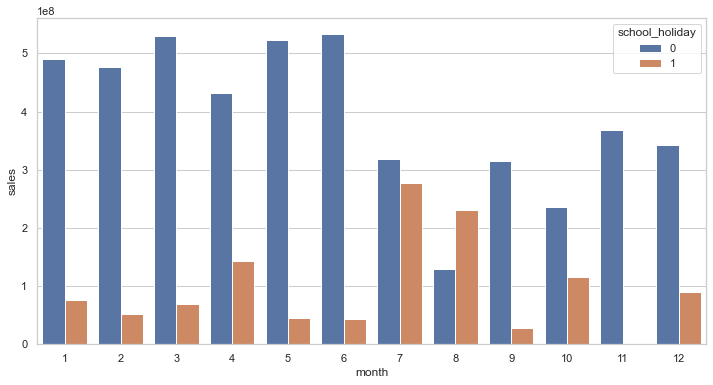

In [91]:
# O total de vendas nos períodos escolares é grande em julho e agosto, pois é a época de férias escolares nos EUA.
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()

sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Resumo das Hipóteses 
- Expectativas Inicais a Respeito das Variáveis
- A Hipótese foi Valida ou Rejeitada? 
- Ela pode gerar um Insight ou não? 
- Ela pode ser Relevante para o Modelo?

In [99]:
tab =[['Hipoteses', 'Conclusao', 'Relevante', 'Correlação'],
      ['H1', 'Verdadeira', 'Sim', 'Baixa'],  
      ['H2', 'Falsa', 'Sim', 'Baixa'],  
      ['H3', 'Falsa', 'Não', 'Média'],
      ['H4', 'Falsa', 'Não', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Não', 'Baixa'],
      ['H7', 'Verdadeira', 'Sim', 'Alta'],
      ['H8', 'Verdadeira', 'Sim', 'Alta'],
      ['H9', 'Falsa', 'Sim', 'Média'],      
      ['H10', 'Falsa', 'Sim', 'Baixa'],
      ['H11', 'Verdadeira', 'Sim', 'Baixa'],
      ['H12', 'Falsa', 'Sim', 'Média'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevante    Correlação
-----------  -----------  -----------  ------------
H1           Verdadeira   Sim          Baixa
H2           Falsa        Sim          Baixa
H3           Falsa        Não          Média
H4           Falsa        Não          Baixa
H5           -            -
H6           Falsa        Não          Baixa
H7           Verdadeira   Sim          Alta
H8           Verdadeira   Sim          Alta
H9           Falsa        Sim          Média
H10          Falsa        Sim          Baixa
H11          Verdadeira   Sim          Baixa
H12          Falsa        Sim          Média


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

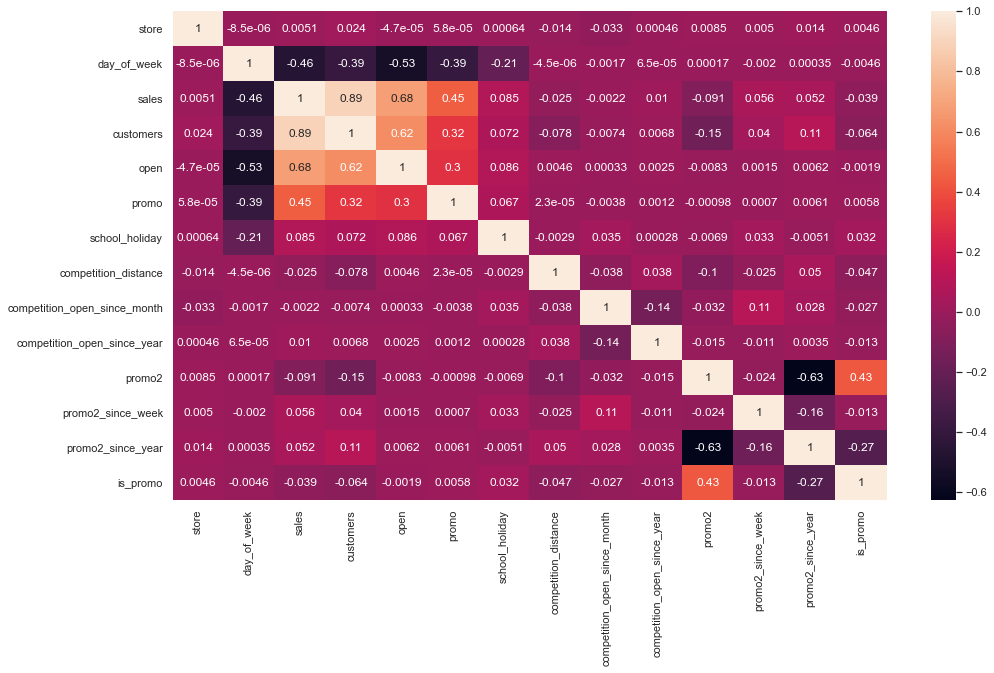

In [105]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(16, 9))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [106]:
cat_attributes.head(3)

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul


In [107]:
# only categorical data
a = df4.select_dtypes(include='object')
a.head(3)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30


In [108]:
a = a.drop('year_week', axis=1)

In [109]:
a.head(1)

,state_holiday,store_type,assortment
0,regular_day,c,basic


In [110]:
tabela_contigencia = pd.crosstab(a['state_holiday'], a['store_type'])
tabela_contigencia

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [111]:
tc = tabela_contigencia.values

In [112]:
# o V de Cramer vai de 0 a 1 
# A função se encontra na seção 0.1 - Helper Functions
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

In [113]:
# calculate Cramer-V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]})

# Final Dataset
d = d.set_index( d.columns )
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


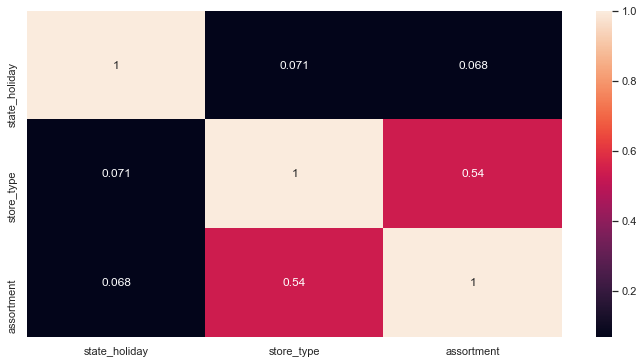

In [114]:
sns.heatmap(d, annot=True);

# 5.0 Data Preparation

In [115]:
df5 = df4.copy()

## 5.1 Pàdronização

## 5.2 Rescaling

In [116]:
a = df5.select_dtypes( include=['int64', 'float64', 'int32'])

In [117]:
a.sample(3)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
679676,312,3,4187,0,0,11300.0,3,2012,0,44,2013,0,2013,10,30,44,20,0
789032,398,3,3689,0,1,1540.0,7,2013,1,1,2012,1,2013,7,24,30,0,82
803639,510,4,7085,0,0,8260.0,7,2013,0,28,2013,0,2013,7,11,28,0,0


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


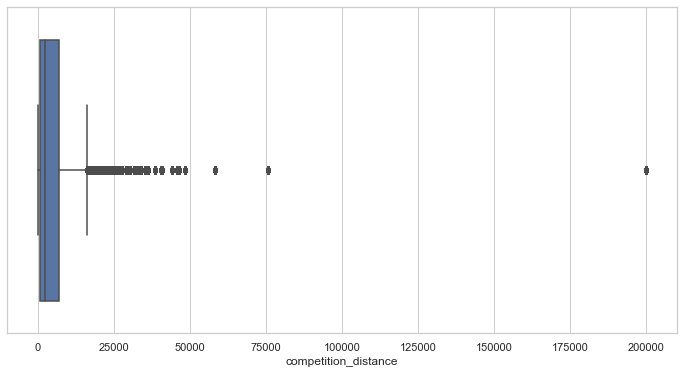

In [118]:
sns.boxplot(df5['competition_distance']);
# possui muitos outliers! inclusive, devem ter muitos pontos sobrepostos nos valores de 200000, que inserimos no lugar das variáveis NA

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


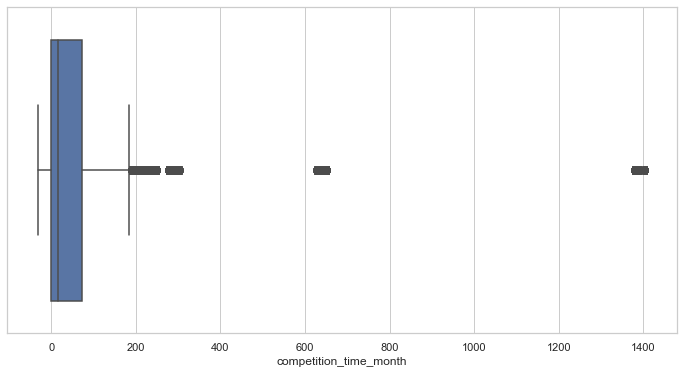

In [119]:
sns.boxplot(df5['competition_time_month']); # muitos outliers também

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


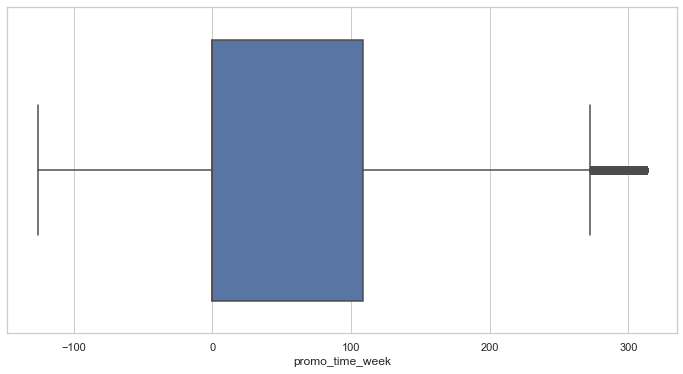

In [120]:
sns.boxplot(df5['promo_time_week']) # tem outliers, mas não parecem tão relevantes, pois estão bem agrupados e sequenciais

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


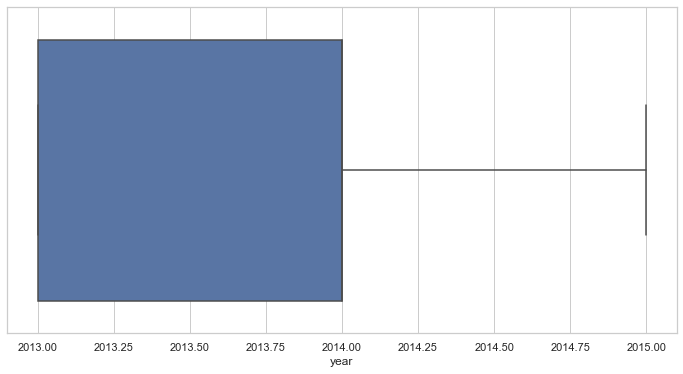

In [121]:
sns.boxplot(df5['year']); # sem outliers

In [122]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( mms, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/year_scaler.pkl', 'wb') )

## 5.3 Feature Transformation

### 5.3.1 Encoding (Variável Categórica --> Variávael Numérica)

In [123]:
df5.sample(5).T

,892924,768113,303599,179176,551290
store,595,664,996,777,151
day_of_week,1,1,2,6,6
date,2013-04-22 00:00:00,2013-08-12 00:00:00,2014-10-21 00:00:00,2015-02-21 00:00:00,2014-02-22 00:00:00
sales,17569,7271,8007,4760,4939
promo,1,1,1,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,1,0,0
store_type,c,d,c,d,d
assortment,extended,extended,basic,extended,extended
competition_distance,-0.193548,-0.104839,0.0870968,0.954839,0.327419


In [124]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [125]:
# store_type - Label Encoding
label_encoder = LabelEncoder()
df5['store_type'] = label_encoder.fit_transform(df5['store_type'])
pickle.dump( label_encoder, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/store_type_encoding.pkl', 'wb') )

In [126]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


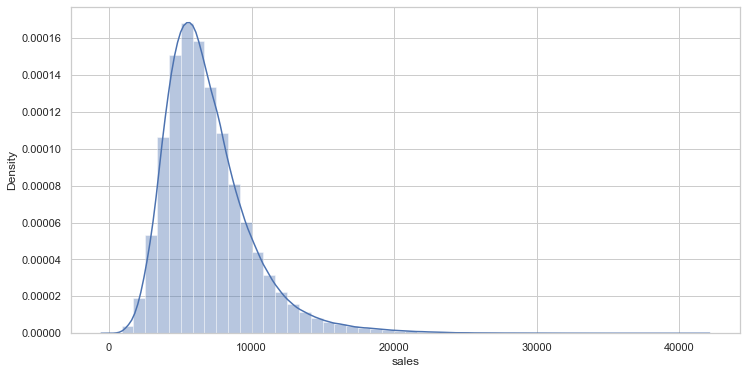

In [127]:
sns.distplot(df5['sales']);

In [128]:
df5['sales'] = np.log1p( df5['sales'] )

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


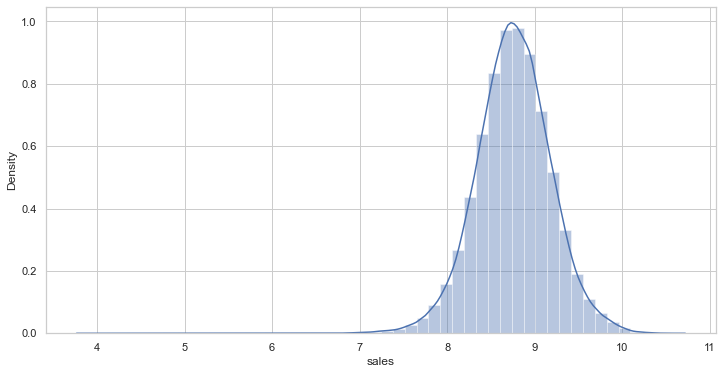

In [129]:
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

Variáveis Cíclicas: Transformação de Natureza Cíclica

In [130]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [131]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test Dataset

In [132]:
# dropar colunas que foram transformadas em outras
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [133]:
# como queremos prever as proximas 6 semanas de venda, vamos usar as 6 ultimas semanas dos dados como teste, e o resto como treino
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [134]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

print('\nTamanho treino: {}'.format(X_train.shape[0]))
print('Tamanho teste: {}'.format(X_test.shape[0]))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00

Tamanho treino: 802942
Tamanho teste: 41396


## 6.2 Boruta as Feature Selector

In [135]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-2 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [136]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [137]:
# foram incluídos os senos do month e do week_of_year, pois não faz sentido ter as funções de cos sem ter o seno no modelo, pois elas juntas é que representam as variáveis originais
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [140]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [141]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )  
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) # exp pois as sales tinham sido transformados pra log
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [142]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [143]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [144]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


### 7.3.1. Lasso - Cross Validation

In [145]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1194.780566139627, tolerance: 11.937395279075517
  positive)
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.41129132863716, tolerance: 12.565835453461386
  positive)


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2088.88 +/- 327.01,0.3 +/- 0.01,2988.6 +/- 499.57


## 7.4 Random Forest Model

In [146]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-2, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [147]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [148]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=200,
                              n_jobs=-2,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[12:15:52] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,4840.199786,0.658697,5550.716612


### 7.5.1. XGBoost Regressor - Cross Validation

In [149]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5
[12:16:54] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[12:17:36] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[12:18:25] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,5159.64 +/- 480.56,0.67 +/- 0.01,5891.75 +/- 590.67


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [150]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137
0,XGBoost Regressor,4840.199786,0.658697,5550.716612


### 7.6.2. Real Performance - Cross Validation

In [151]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2088.88 +/- 327.01,0.3 +/- 0.01,2988.6 +/- 499.57
0,XGBoost Regressor,5159.64 +/- 480.56,0.67 +/- 0.01,5891.75 +/- 590.67


Estes resultados implicam que o fenômeno estudado (previsão de vendas) é complexo, e portanto, modelos mais simples (como os lineares) não funcionam bem para este problema.

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [152]:
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [153]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
       
# final_result

In [154]:
#final_result

In [155]:
# # Usando Sklearn:
# random_search = RandomizedSearchCV(
#     model_xgb,
#     param,
#     n_jobs=-3,
#     n_iter=32,
#     random_state=0,
#     cv=5
#  )
# RandomizedSearchCV.fit(x_train, y_train)
# RandomizedSearchCV.score(x_test, y_test)

## 8.2 Grid Search

In [156]:
# grid_search = GridSearchCV(
#     model_xgb,
#     param,
#     n_jobs=-3,
#     n_iter=32,
#     random_state=0,
#     cv=5
#  )
# GridSearchCV.fit(x_train, y_train)
# GridSearchCV.score(x_test, y_test)

## 8.3 Bayesian Search

In [157]:
# bayes_search = BayesSearchCV(
#     model_xgb,
#     param,
#     n_jobs=-3,
#     n_iter=32,
#     random_state=0,
#     cv=5
#  )
# bayes_search.fit(x_train, y_train)
# bayes_search.score(x_test, y_test)

## 8.4 Final Model

In [158]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [162]:
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

[12:31:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056209,0.114528,1088.442059


In [163]:
# mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# mpe  # o modelo está superestimando as sales

-0.01954731652908409

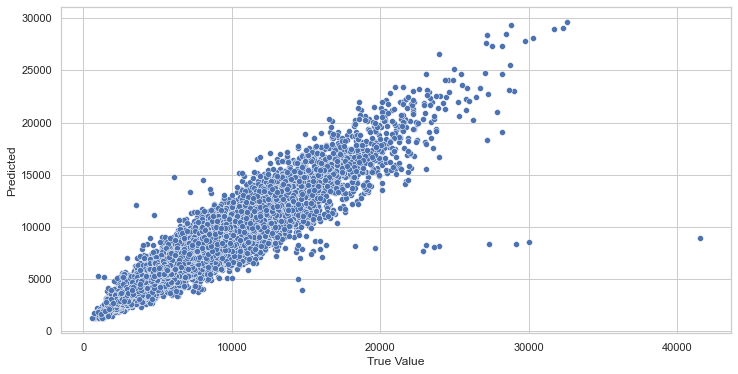

In [164]:
sns.scatterplot(x=np.expm1( y_test ), y=np.expm1( yhat_xgb_tuned ));
plt.xlabel('True Value');
plt.ylabel('Predicted');

# por esse gráfico, pareece que o modelo está subestimando as sales... mas o MPE deu levemente negativo, o que indica o contrário

In [183]:
#	Model Name	            MAE	       MAPE	       RMSE             MPE
#0	XGBoost Regressor	760.056209	0.114528	1088.442059   -0.01954731652908409

# 9.0 Tradução e Interpretação do Erro

In [166]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9.loc[:, 'sales'] = np.expm1( df9.loc[:, 'sales'] )
df9.loc[:, 'predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


## 9.1 Business Performacne

In [167]:
# O quanto de receita vai entrar no meu modelo?
df9_sum = df9[['store', 'predictions']].groupby('store').sum().reset_index()
df9_mean = df9[['store', 'predictions']].groupby('store').mean().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux4 = pd.merge(df9_mean, df9_aux3, how='inner', on='store')
df92 = pd.merge(df9_sum, df9_aux4, how='inner', on='store').rename(columns={'predictions_x': 'sum_predictions', 'predictions_y': 'mean_predictions'})

# Scenarios
df92['daily_worst_scenario'] = df92['mean_predictions'] - df92['MAE']
df92['daily_best_scenario'] = df92['mean_predictions'] + df92['MAE']

df92['6_week_worst_scenario'] = df92['sum_predictions'] - df92['MAPE'] * df92['sum_predictions']
df92['6_week_best_scenario'] = df92['sum_predictions'] + df92['MAPE'] * df92['sum_predictions']
# sum predictions é a soma das vendas previstas para as próximas 6 semanas de cada loja

In [168]:
df92.head()

,store,sum_predictions,mean_predictions,MAE,MAPE,daily_worst_scenario,daily_best_scenario,6_week_worst_scenario,6_week_best_scenario
0,1,168661.593750,4558.421875,303.999301,0.070709,4254.422574,4862.421176,156735.692899,180587.494601
1,2,179764.843750,4858.509277,458.832236,0.092513,4399.677042,5317.341513,163134.298884,196395.388616
2,3,273038.718750,7379.424805,747.590042,0.103935,6631.834763,8127.014846,244660.395589,301417.041911
3,4,349241.093750,9438.948242,766.110101,0.073254,8672.838141,10205.058343,323657.661223,374824.526277
4,5,170625.953125,4611.512207,333.229142,0.077871,4278.283065,4944.741350,157339.223437,183912.682813


In [169]:
# lojas difíceis de lidar com as previsões, erro percentual muito alto!!!
df92.sort_values('MAPE', ascending=False).head()

,store,sum_predictions,mean_predictions,MAE,MAPE,daily_worst_scenario,daily_best_scenario,6_week_worst_scenario,6_week_best_scenario
291,292,106847.437500,5623.549316,3359.866995,0.588682,2263.682322,8983.416311,43948.285559,169746.589441
908,909,228641.281250,9940.924805,7735.849206,0.515674,2205.075599,17676.774011,110736.997021,346545.565479
169,170,207574.890625,5610.132324,1503.321342,0.372452,4106.810982,7113.453666,130263.294057,284886.487193
875,876,202657.421875,8811.192383,3944.024064,0.317062,4867.168319,12755.216447,138402.462754,266912.380996
594,595,370526.312500,10014.224609,4288.829405,0.295611,5725.395204,14303.054014,260994.610487,480058.014513


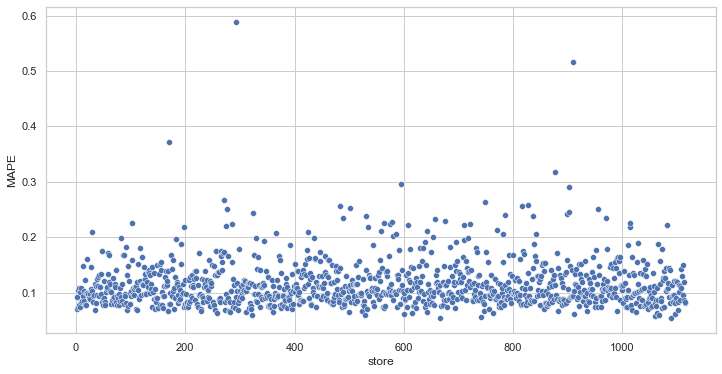

In [170]:
sns.scatterplot(x='store', y='MAPE', data=df92)

Realmente, existem lojas mais desafiadoras do que as outras, mas no geral estão em torno de um MAPE de 10%

## 9.2 Total Performance

In [171]:
df93 = df92[['sum_predictions', '6_week_worst_scenario', '6_week_best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,sum_predictions,"R$ 287,261,338.44"
1,6_week_worst_scenario,"R$ 255,110,894.25"
2,6_week_best_scenario,"R$ 319,411,782.62"


## 9.3 Machine Learning Performance

In [172]:
df9.loc[:, 'error'] = df9.loc[:, 'sales'] - df9.loc[:, 'predictions']
df9.loc[:, 'error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'sales']

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


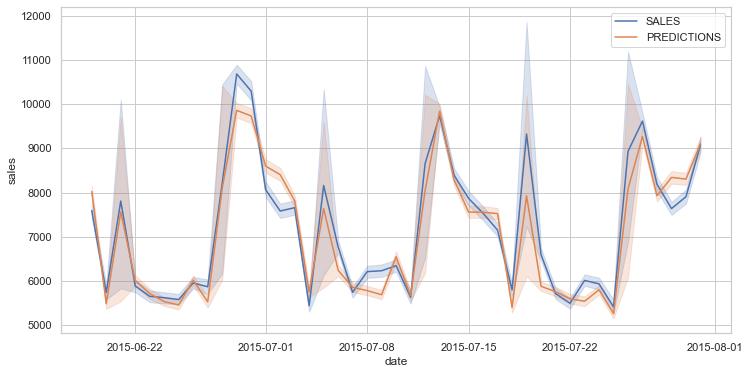

In [173]:
# By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

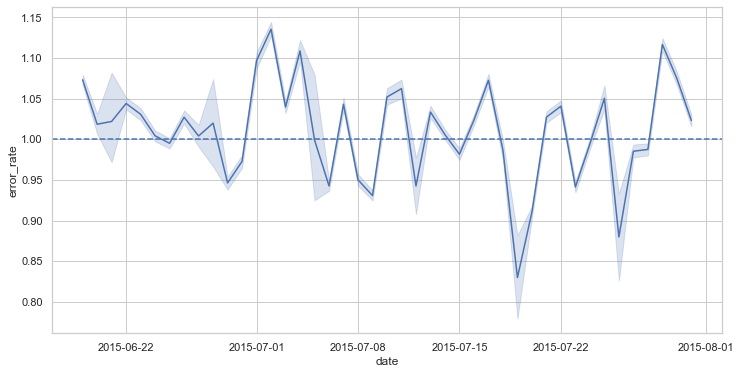

In [174]:
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


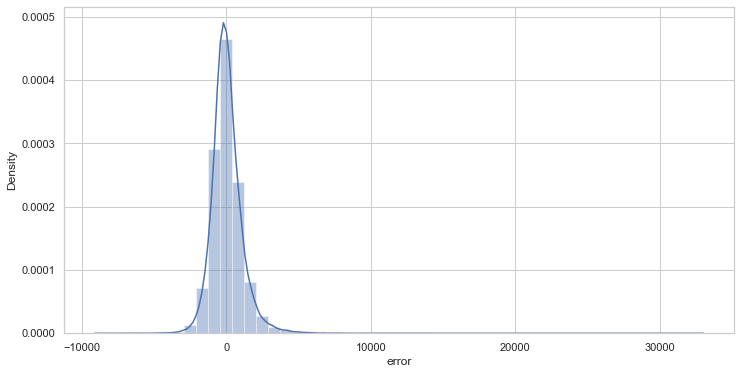

In [175]:
sns.distplot( df9['error'] )
# o erro segue uma distribuição normal, é um bom sinal de que não há viés e coisa do tipo (estudar análise de resíduos)

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


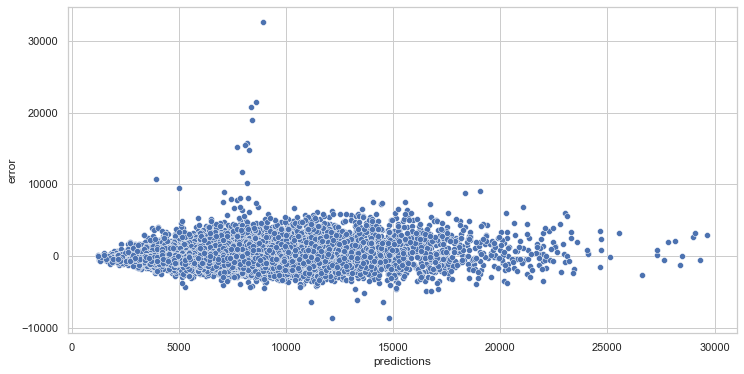

In [176]:
sns.scatterplot( df9['predictions'], df9['error'] )
# tirando alguns outliers de previsões entre 6mil e  9mil, o modelo possui um erro bem constante e aleatório, sem muitos outliers, o que também é um bom sinal

# 10 DEPLOY MODEL TO PRODUCTION

In [178]:
# save trained model
#pickle.dump( model_xgb_tuned, open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/model/model_rossman_xgb_tuned.pkl', 'wb' ) )

## 10.1 Rossman Class

In [179]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import requests

class Rossman(object):
    def __init__(self):
        #self.home_path = 'D:\MEGA\Programming\Data Science\Data Science em Produção - Meigarom\predit_sales\'     aí faz home_path + data/nome do arquivo, etc
        self.competition_distance_scaler   = pickle.load(open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding           = pickle.load(open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/parameter/store_type_encoding.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns
        # sales e customers es tão fora pois sales é o que queremos prever, e customers não temos como saber o número futuro, então o test.csv não possui estas duas colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'] 
                                                                                                                                        
        #cols_old = df1.columns  pleonasmo, talvez fosse melhor usar esse que é mais enxuto, mas enfim...

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_distance
        # provavelmente, a distância é NA porque o competidor mais próximo fica muito longe, entõa considera-se que não tem competitior próximo. Podemos colocar um valor grande referente ao maior
        # encontrado na coluna para preencher os NA
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year                       
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval     
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # promo_interval     
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Change Types   -  após fazer operações com colunas, verificar novamente os tipos das colunas

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    

    def feature_engineering(self, df2):

        ## 2.3 Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)  
        # não temos informação do dia, entao estamos supondo que começa dia 1 sempre
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0 Filtragem de Variáveis

        ## 3.1 Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2 Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        
        # DATA PREPARATION
        
        ## 5.1 Padronização

        ## 5.2 Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        ## 5.3 Feature Transformation

        ### 5.3.1 Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        label_encoder = LabelEncoder()
        df5['store_type'] = self.store_type_encoding.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation

        # Variáveis Cíclicas: Transformação de Natureza Cíclica

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                                'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_predictions(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join red into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format='iso')

In [180]:
# testar classe
teste = Rossman()

In [181]:
df_teste = df5['competition_distance'] = mms.fit_transform( df5[['competition_distance']].values.reshape(-1, 1) )
df_teste
df2['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

## 10.2 API Handler

In [182]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/model/model_rossman_xgb_tuned.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv('D:/MEGA/Programming/Data Science/Data Science em Produção - Meigarom/predit_sales/data/test.csv')

In [ ]:
# lista com todos os números de lojas
unique_stores = set(np.unique(df10.Store.values))

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [20, 22, 23] )]  # código das lojas que você quer
#df_test = df_test[df_test['Store'].isin( random.sample(unique_stores, 5) )] # escolhendo 5 lojas aleatoariamente

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
df_test = df_test[df_test['Store'] == random.sample(unique_stores, 1)[0] ]

In [ ]:
df_test

In [ ]:
random.sample(unique_stores, 1)
type(random.sample(unique_stores, 1))

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'  # --> url local
url = 'https://rossman-model.herokuapp.com/rossmann/predict'  # --> url nuvem heroku
header = {'Content-type': 'application/json' } 
data = data

response = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( response.status_code ) )
# Status Code 200 --> deu certo
# 503 --> existe a url, mas o servidor está fora por algum motivo // ou o servidor demorou pra responder
# 404 --> não existe a url
# 500 -> Quando o servidor retorna um código de erro (HTTP) 500, indica que encontrou uma condição inesperada e que o impediu de atender à solicitação. Essa resposta de erro é uma resposta genérica "abrangente"
# quando der algum erro, olhar nos logs do heroku pra ver se tem erro de código

In [ ]:
d1 = pd.DataFrame( response.json(), columns=response.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

In [ ]:
d1.sample()